## EOF for nightlights
This notebook is to analyze EOF for [nightlights](https://ngdc.noaa.gov/eog/dmsp/downloadV4composites.html) data. Key steps:
1. Construct temporal array for nightlights data (time x lat x long)
2. Conduct EOF
3. Manually analyze images produced as a result

In [2]:
import numpy as np
import os
# import eofs
# import tqdm
# import matplotlib.pyplot as plt
import rasterio as rio
from rasterio.plot import show, show_hist
from rasterio.mask import mask
from shapely.geometry import Polygon, mapping
import seaborn as sns
import jupyterthemes
from jupyterthemes import jtplot
jupyterthemes.jtplot.style('onedork')
sns.set()

In [3]:
import matplotlib.pyplot as plt

## Construct temporal array for nightlights data
1. Download nightlights data for years 1990 - 2015
2. Extract nightlights at reduced granularity and append to a list.
3. Save the list and load for later analysis

In [4]:
! ls data/nightlights/

F101993.v4  F141998.v4	F152003.v4  F162008.v4	F182013.v4
F121994.v4  F141999.v4	F162004.v4  F162009.v4	new.tif
F121995.v4  F152000.v4	F162005.v4  F182010.v4	nlight_downsampled_combined.pkl
F121996.v4  F152001.v4	F162006.v4  F182011.v4
F141997.v4  F152002.v4	F162007.v4  F182012.v4


In [5]:
import sys


In [6]:
base_path = './data/nightlights/'
import fnmatch
def get_tif_paths(base_path):
    tif_paths = []
    for dirname in os.listdir(base_path):
        filename = os.path.join(base_path, dirname)
        if os.path.isdir(filename):
            tif_paths.append(filename)
#     print(tif_paths)
    tif_p = []
    for d in tif_paths:
        for f in os.listdir(d):
            if fnmatch.fnmatch(f, "*.tif"):
                tif_p.append(os.path.join(d, f))
        
    return tif_p
tif_paths = get_tif_paths(base_path)
print(len(tif_paths))
print(tif_paths)
# def extract_tif(filepath):
    

46
['./data/nightlights/F101993.v4/F101993.v4b_web.stable_lights.avg_vis_downsampled.tif', './data/nightlights/F101993.v4/F101993.v4b_web.stable_lights.avg_vis_downsampled_downsampled.tif', './data/nightlights/F101993.v4/F101993.v4b_web.stable_lights.avg_vis.tif', './data/nightlights/F182011.v4/F182011.v4c_web.stable_lights.avg_vis_downsampled.tif', './data/nightlights/F182011.v4/F182011.v4c_web.stable_lights.avg_vis.tif', './data/nightlights/F121994.v4/F121994.v4b_web.stable_lights.avg_vis_downsampled_downsampled.tif', './data/nightlights/F121994.v4/F121994.v4b_web.stable_lights.avg_vis.tif', './data/nightlights/F121994.v4/F121994.v4b_web.stable_lights.avg_vis_downsampled.tif', './data/nightlights/F162006.v4/F162006.v4b_web.stable_lights.avg_vis.tif', './data/nightlights/F162006.v4/F162006.v4b_web.stable_lights.avg_vis_downsampled.tif', './data/nightlights/F141998.v4/F141998.v4b_web.stable_lights.avg_vis.tif', './data/nightlights/F141998.v4/F141998.v4b_web.stable_lights.avg_vis_downsa

What do all the above files mean? Which one to choose? How to work with raster?


From [description page](https://ngdc.noaa.gov/eog/gcv4_readme.txt): 
* Each tar ball contains the raw average visible band, cleaned up average visible band, cloud free coverage data, and a readme file. 
* The data files have been compressed with gzip.

For us, the useful file is then F1?YYYY_v4b_stable_lights.avg_vis.tif

To work with this tiff data, we'll use GDAL and rasterio libraries.

[This](https://annefou.github.io/metos_python/02-formats/) is a good tutorial on basic python data formats

In [7]:
nlight_path = tif_paths[0]
# open raster data
with rio.open(nlight_path) as src:
    nlight = src.read(masked=True, indexes = 1)
    nlight_meta = src.profile
    nlight_extent = rio.plot.plotting_extent(src)
print(nlight_extent)
print(nlight_meta)
print(nlight.shape)
print(type(nlight))

(-180.00416666665, 180.00416522664995, -65.00416610665, 75.00416666665)
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 4320, 'height': 2160, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.08333526201233796, 0.0, -180.00416666665,
       0.0, -0.06481867258023148, 75.00416666665), 'tiled': False, 'interleave': 'band'}
(2160, 4320)
<class 'numpy.ma.core.MaskedArray'>


## Let's plot the nighlights!

In [47]:
# let's turn off interactive mode so only show command plots in jupyter 
# Turn interactive plotting off
plt.ion()

In [34]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(nlight)
plt.savefig('plots/nlight_0.png', dpi=100)

## Nightlights dataset needs to be resampled, else calculating EOF components will be very computation instensive.
* Get the required dimensions
* Reproject using raster functions

Now that we've seen the raster, we need to downsample it for further analysis as it just takes way to long to even plot, one way is 

In [8]:
from rasterio.warp import calculate_default_transform, reproject, Resampling
def resample_raster(src_file, dest_file, dest_lon_size, dest_lat_size):
    with rio.open(src_file) as src:
        dst_crs = src.crs
        #Get the transform required ...
        transform, width, height = calculate_default_transform(
            src.crs, 
            dst_crs, 
            src.width, 
            src.height, 
            *src.bounds,
            dst_width = dest_lon_size,
            dst_height = dest_lat_size,
        )
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': dest_lon_size,
            'height': dest_lat_size,
        })
        with rio.open(dest_file, 'w', **kwargs) as dst:
                for i in range(1, src.count + 1):
                    reproject(
                        source=rio.band(src, i),
                        destination=rio.band(dst, i),
                        src_transform=src.transform,
                        src_crs=src.crs,
                        dst_transform=transform,
                        dst_crs=dst_crs,
                        resampling=Resampling.average)

(-180.00416666665, 180.00416522664995, -65.00416610665, 75.00416666665)
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 4320, 'height': 2160, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.08333526201233796, 0.0, -180.00416666665,
       0.0, -0.06481867258023148, 75.00416666665), 'tiled': False, 'interleave': 'band'}
(2160, 4320)
<class 'numpy.ma.core.MaskedArray'>


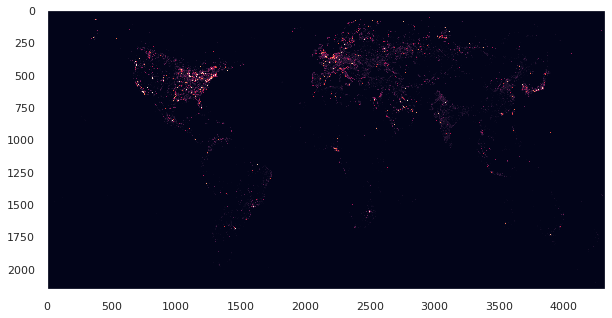

In [93]:
# open raster data
# Plotting a sample as genrated above
with rio.open('./data/nightlights/new.tif') as src:
    nlight = src.read(masked=True, indexes = 1)
    nlight_meta = src.profile
    nlight_extent = rio.plot.plotting_extent(src)
print(nlight_extent)
print(nlight_meta)
print(nlight.shape)
print(type(nlight))

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(nlight.data)
ax.grid(False)
# plt.savefig('plots/nlight_0.png', dpi=100)

In [94]:
latdim, londim = 2160, 4320
for file in tif_paths:
    dst_path = file[:-4]+"_downsampled.tif"
    resample_raster(file, dst_path, londim, latdim)
    print(dst_path, " .. done")

./data/nightlights/F101993.v4/F101993.v4b_web.stable_lights.avg_vis_downsampled_downsampled.tif  .. done
./data/nightlights/F101993.v4/F101993.v4b_web.stable_lights.avg_vis_downsampled.tif  .. done
./data/nightlights/F182011.v4/F182011.v4c_web.stable_lights.avg_vis_downsampled.tif  .. done
./data/nightlights/F121994.v4/F121994.v4b_web.stable_lights.avg_vis_downsampled.tif  .. done
./data/nightlights/F121994.v4/F121994.v4b_web.stable_lights.avg_vis_downsampled_downsampled.tif  .. done
./data/nightlights/F162006.v4/F162006.v4b_web.stable_lights.avg_vis_downsampled.tif  .. done
./data/nightlights/F141998.v4/F141998.v4b_web.stable_lights.avg_vis_downsampled.tif  .. done
./data/nightlights/F121995.v4/F121995.v4b_web.stable_lights.avg_vis_downsampled_downsampled.tif  .. done
./data/nightlights/F121995.v4/F121995.v4b_web.stable_lights.avg_vis_downsampled.tif  .. done
./data/nightlights/F162008.v4/F162008.v4b_web.stable_lights.avg_vis_downsampled.tif  .. done
./data/nightlights/F141999.v4/F141

## Load the downsampled tif and perform EOF analysis
* construct the file list
* construct numpy array with first dimension as time dimension
* Save the numpy array for future use
* Run EOF and visualize results

In [12]:
tif_paths

['./data/nightlights/F101993.v4/F101993.v4b_web.stable_lights.avg_vis_downsampled.tif',
 './data/nightlights/F101993.v4/F101993.v4b_web.stable_lights.avg_vis.tif',
 './data/nightlights/F182011.v4/F182011.v4c_web.stable_lights.avg_vis_downsampled.tif',
 './data/nightlights/F182011.v4/F182011.v4c_web.stable_lights.avg_vis.tif',
 './data/nightlights/F121994.v4/F121994.v4b_web.stable_lights.avg_vis_downsampled_downsampled.tif',
 './data/nightlights/F121994.v4/F121994.v4b_web.stable_lights.avg_vis.tif',
 './data/nightlights/F121994.v4/F121994.v4b_web.stable_lights.avg_vis_downsampled.tif',
 './data/nightlights/F162006.v4/F162006.v4b_web.stable_lights.avg_vis.tif',
 './data/nightlights/F162006.v4/F162006.v4b_web.stable_lights.avg_vis_downsampled.tif',
 './data/nightlights/F141998.v4/F141998.v4b_web.stable_lights.avg_vis.tif',
 './data/nightlights/F141998.v4/F141998.v4b_web.stable_lights.avg_vis_downsampled.tif',
 './data/nightlights/F121995.v4/F121995.v4b_web.stable_lights.avg_vis_downsample

In [15]:
donwsampled_dir = "./data/nlights_downsampled"
f_list = [os.path.join(donwsampled_dir, x) for x in os.listdir(downsampled_dir)]
nlights = {
    'year':[],
    'data':[],
    'profile':[],
    'extent':[]
          }

for f in f_list:
    with rio.open(f) as src:
        print(f)
#         year = extract_year(f)
        nlight = src.read(masked=True, indexes = 1)
        nlights['data'].append(nlight.data)
        nlights['extent'].append(rio.plot.plotting_extent(src))
        nlights['profile'].append(src.profile)


import pickle
with open('./data/nightlights/nlight_downsampled_combined.pkl', 'wb') as fp:
    pickle.dump(nlights, fp)

./data/nlights_downsampled/F121995.v4b_web.stable_lights.avg_vis_downsampled.tif
./data/nlights_downsampled/F182011.v4c_web.stable_lights.avg_vis_downsampled.tif
./data/nlights_downsampled/F162007.v4b_web.stable_lights.avg_vis_downsampled.tif
./data/nlights_downsampled/F141999.v4b_web.stable_lights.avg_vis_downsampled.tif
./data/nlights_downsampled/F141997.v4b_web.stable_lights.avg_vis_downsampled.tif
./data/nlights_downsampled/F152002.v4b_web.stable_lights.avg_vis_downsampled.tif
./data/nlights_downsampled/F162005.v4b_web.stable_lights.avg_vis_downsampled.tif
./data/nlights_downsampled/F182013.v4c_web.stable_lights.avg_vis_downsampled.tif
./data/nlights_downsampled/F121994.v4b_web.stable_lights.avg_vis_downsampled.tif
./data/nlights_downsampled/F162004.v4b_web.stable_lights.avg_vis_downsampled.tif
./data/nlights_downsampled/F141998.v4b_web.stable_lights.avg_vis_downsampled.tif
./data/nlights_downsampled/F101993.v4b_web.stable_lights.avg_vis_downsampled.tif
./data/nlights_downsampled/F

# Perform EOF analysis on nightlights
* Read the data from pkl